In [1]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [2]:
log_reg_model = pickle.load(open('logistic_regression_completion_third_quarter.p', 'rb')) # load the model

In [3]:
# model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=10, multi_class='warn',
#           n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
#           tol=1e-09, verbose=0, warm_start='False')

In [4]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)

def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label='Logistic Regression', 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()


In [5]:
# X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
# y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/third_quarter/X_test.csv')

y_test = pd.read_csv('../data/processed/third_quarter/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
# X_train.fillna(value = 0, inplace = True)
# X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)

high_vif = ['module_presentation_length', 'sum_days_vle_accessed', 'score_first_assessment', 'days_early_first_assessment']
# X_train.drop(high_vif, axis = 1, inplace = True)
X_test.drop(high_vif, axis = 1, inplace = True)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [6]:
# model.fit(X_train, y_train)

In [7]:
    predictions = log_reg_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = log_reg_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    class_report = classification_report(y_test, predictions)

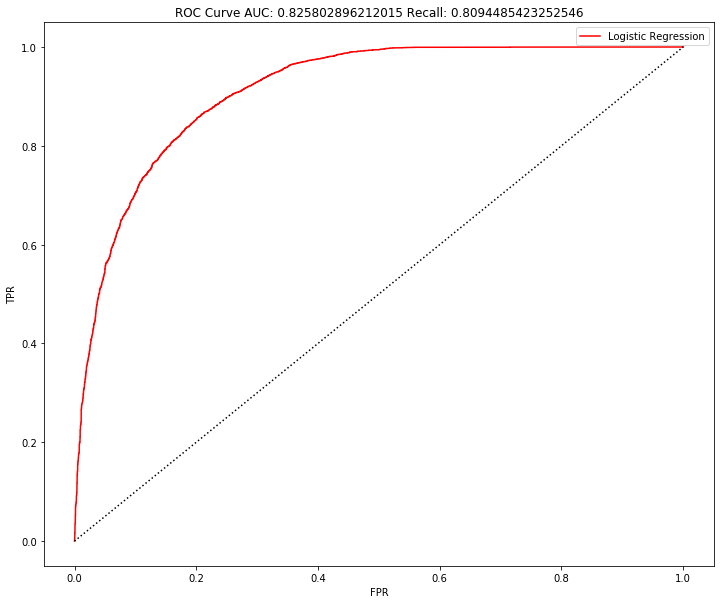

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=1e-09, verbose=0, warm_start='False')

Roc Auc: 0.825802896212015

Recall Score: 0.8094485423252546

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.84      0.82      5062
        True       0.85      0.81      0.83      5694

   micro avg       0.82      0.82      0.82     10756
   macro avg       0.82      0.83      0.82     10756
weighted avg       0.83      0.82      0.82     10756


Confusion Matrix:
 [[4609  799]
 [1085 4263]]


In [8]:
    print_roc_curve(y_test, probas)
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [9]:
    # Feature Importances
    abs_coef = list(np.abs(log_reg_model.coef_.ravel()))
    features = list(X_test.columns)
    coef_dict = c.OrderedDict((zip(abs_coef, features)))
    print('The top ten features affecting completion are:\n')
    sorted(coef_dict.items(), reverse=True)[:10]

The top ten features affecting completion are:



[(1.8225626057928486, 'avg_score'),
 (1.352821698439812, 'code_module_EEE'),
 (1.2498326549121066, 'code_module_FFF'),
 (1.218890104479497, 'code_module_CCC'),
 (1.0346852782580653, 'code_module_GGG'),
 (0.9587680687403675, 'sum_click_folder'),
 (0.8584320978511739, 'sum_click_oucontent'),
 (0.8576594637901173, 'imd_band_nan'),
 (0.6608571803713236, 'code_module_DDD'),
 (0.6350108861855241, 'highest_education_No Formal quals')]

In [10]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:100]

,fprs,tprs,Thresholds
800,0.084651,0.666337,0.689434
900,0.097295,0.697748,0.660904
1000,0.109413,0.728566,0.636200
1100,0.124341,0.751482,0.613819
1200,0.139972,0.778744,0.584861
1300,0.156656,0.800277,0.557656
1400,0.173867,0.822600,0.527414
1500,0.190376,0.842157,0.500140
1600,0.204601,0.858949,0.475928
1700,0.225676,0.875148,0.446224
